In [16]:
import numpy as np

import torch
import pickle as pkl
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
use_cuda = torch.cuda.is_available()
# device = torch.device('cuda:6') if use_cuda else torch.device('cpu')

In [17]:
'loading data..'
with open('./data/diffusion_process_1d_pt.pkl','rb') as f:
    data = pkl.load(f)[:,:50,:]
data = torch.tensor(data,dtype=torch.float)
data.shape

torch.Size([50, 50, 100])

In [18]:

L = data.shape[-1]
pred_step = 1
data_x = data[:,:-pred_step,:].reshape(-1,L)
data_y = data[:,pred_step:,:].reshape(-1,L)
data_x.shape

torch.Size([2450, 100])

In [19]:

batch_size = 64
valid_ratio = 0.2
test_ratio = 0.2
cut1 = int((valid_ratio+test_ratio)*data_x.shape[0])
cut2 =  int(test_ratio*data_x.shape[0])
print(cut1,cut2)
train_data_x = data_x[:cut1,:]
train_data_y = data_y[:cut1,:]
valid_data_x = data_x[cut1:cut1+cut2,:]
valid_data_y = data_y[cut1:cut1+cut2,:]

print(train_data_x.shape,valid_data_x.shape)
dataset1 = torch.utils.data.dataset.TensorDataset(train_data_x, train_data_y)
dataset2 = torch.utils.data.dataset.TensorDataset(valid_data_x, valid_data_y)

train_loader = torch.utils.data.DataLoader(dataset=dataset1,
                                           batch_size=batch_size, 
                                           shuffle=False)

valid_loader = torch.utils.data.DataLoader(dataset=dataset2,
                                           batch_size=batch_size, 
                                           shuffle=True)


980 490
torch.Size([980, 100]) torch.Size([490, 100])


In [26]:
import torch.nn.functional as F
kernel_size = 5
class NormalizedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,padding,padding_mode):
        super(NormalizedConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding, padding_mode, bias=False)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        # 对权重进行归一化 normalize the weight
        normed_weight = self.softmax(self.conv.weight)
        return F.conv1d(x, normed_weight, self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation)

class Diffusion1D(nn.Module):
    def __init__(self,channel=1):
        super(Diffusion1D, self).__init__()
        kernel = kernel_size
        self.normconv = NormalizedConv1d(1, channel, kernel, padding=1, padding_mode='same')
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.normconv(x.unsqueeze(1))

        x = torch.transpose(x,2,1).squeeze()
        return x

In [27]:
NEAR_ZERO = 1e-10

In [24]:
''
loss_kl = torch.nn.KLDivLoss(reduction='batchmean')
loss_F2 = torch.nn.MSELoss()
L = data.shape[-1]
seed = 2051
num_epochs = 10000
hidden_size = 8
torch.manual_seed(seed)
random.seed(seed)
model = Diffusion1D()
model = model.cuda() if use_cuda else model
optimizer2 = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
last_valid_loss = 10000
count = 0
train_losses2 = []
valid_losses2 = []
for epoch in tqdm(range(num_epochs)):
    loss_t2 = []
    loss_v2 = []
    model.train()
    for train_x,train_y in train_loader:
        if use_cuda:
            train_x = train_x.cuda()
        b,l = train_x.shape
        pred = model(train_x)
        loss = loss_kl(torch.log(pred.view(-1,l)+NEAR_ZERO), train_y.view(-1,l)+NEAR_ZERO)
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        loss_t2.append(loss.item())
    train_losses2.append(np.mean(loss_t2))
    if epoch % 20 == 0:
        model.eval()
        for valid_x,valid_y in valid_loader:
            if use_cuda:
                valid_x = valid_x.cuda()
            pred = model(valid_x)
            loss = loss_kl(torch.log(pred.view(-1,l)+NEAR_ZERO), valid_y.view(-1,l)+NEAR_ZERO)
            loss_v2.append(loss.item())
        valid_losses2.append(np.mean(loss_v2))
        if np.mean(loss_v2) > last_valid_loss:
            count += 1
            if count > 100:
                break
        if np.mean(loss_v2) < last_valid_loss:
            count = 0
            print('save',np.mean(loss_v2))
            torch.save(model,f'./models/dynamic/diffusion_dynamic_k={kernel_size}_{seed}.pth')
            last_valid_loss = np.mean(loss_v2)

        print(f'epoch: {epoch}/{num_epochs}: train loss:{np.mean(loss_t2)},valid_loss:{np.mean(loss_v2)}')

  0%|▏                                                                                                           | 13/10000 [00:00<02:34, 64.58it/s]

save 0.01981648406945169
epoch: 0/10000: train loss:0.019288893454358913,valid_loss:0.01981648406945169


  0%|▎                                                                                                           | 29/10000 [00:00<02:19, 71.44it/s]

save 0.010917522595264018
epoch: 20/10000: train loss:0.010476746465428732,valid_loss:0.010917522595264018


  1%|▌                                                                                                           | 53/10000 [00:00<02:13, 74.61it/s]

save 0.0060981756541877985
epoch: 40/10000: train loss:0.006009603788697859,valid_loss:0.0060981756541877985


  1%|▋                                                                                                           | 69/10000 [00:00<02:13, 74.64it/s]

save 0.0038265593902906403
epoch: 60/10000: train loss:0.0037667921014872263,valid_loss:0.0038265593902906403


  1%|█                                                                                                           | 93/10000 [00:01<02:18, 71.37it/s]

save 0.002691294954274781
epoch: 80/10000: train loss:0.0025775734520721016,valid_loss:0.002691294954274781


  1%|█▏                                                                                                         | 109/10000 [00:01<02:16, 72.61it/s]

save 0.0019836576975649223
epoch: 100/10000: train loss:0.0019103248148439889,valid_loss:0.0019836576975649223


  1%|█▍                                                                                                         | 133/10000 [00:01<02:16, 72.40it/s]

save 0.0015206949283310678
epoch: 120/10000: train loss:0.001513778765911411,valid_loss:0.0015206949283310678


  1%|█▌                                                                                                         | 149/10000 [00:02<02:13, 73.54it/s]

save 0.0012872336992586497
epoch: 140/10000: train loss:0.001265545230353382,valid_loss:0.0012872336992586497


  2%|█▊                                                                                                         | 173/10000 [00:02<02:09, 75.65it/s]

save 0.0011809719508164562
epoch: 160/10000: train loss:0.001104503694136838,valid_loss:0.0011809719508164562


  2%|██                                                                                                         | 189/10000 [00:02<02:08, 76.43it/s]

save 0.0010456512463861145
epoch: 180/10000: train loss:0.0009983674956401956,valid_loss:0.0010456512463861145


  2%|██▎                                                                                                        | 213/10000 [00:02<02:06, 77.43it/s]

save 0.0009411003738932777
epoch: 200/10000: train loss:0.0009284304265975152,valid_loss:0.0009411003738932777


  2%|██▍                                                                                                        | 229/10000 [00:03<02:06, 77.17it/s]

epoch: 220/10000: train loss:0.0008829541699242327,valid_loss:0.0009523231201455928


  2%|██▌                                                                                                        | 245/10000 [00:03<02:10, 74.53it/s]

epoch: 240/10000: train loss:0.0008538783520180004,valid_loss:0.0009664910267019877


  3%|██▉                                                                                                        | 269/10000 [00:03<02:19, 69.86it/s]

save 0.0008854330535541521
epoch: 260/10000: train loss:0.0008356388151469218,valid_loss:0.0008854330535541521


  3%|███▏                                                                                                       | 293/10000 [00:04<02:18, 69.88it/s]

epoch: 280/10000: train loss:0.0008244028128956415,valid_loss:0.0008875341427483363


  3%|███▎                                                                                                       | 309/10000 [00:04<02:18, 69.73it/s]

save 0.0008639541265438311
epoch: 300/10000: train loss:0.0008176205676591053,valid_loss:0.0008639541265438311


  3%|███▌                                                                                                       | 333/10000 [00:04<02:14, 71.89it/s]

save 0.0008288293465739116
epoch: 320/10000: train loss:0.0008135937381439362,valid_loss:0.0008288293465739116


  3%|███▋                                                                                                       | 349/10000 [00:04<02:15, 71.42it/s]

save 0.0008232842046709266
epoch: 340/10000: train loss:0.0008112541236187099,valid_loss:0.0008232842046709266


  4%|███▉                                                                                                       | 372/10000 [00:05<02:24, 66.73it/s]

epoch: 360/10000: train loss:0.0008099156381149442,valid_loss:0.0008499047798977699


  4%|████▏                                                                                                      | 388/10000 [00:05<02:18, 69.24it/s]

epoch: 380/10000: train loss:0.0008091410611541505,valid_loss:0.0008754067603149451


  4%|████▍                                                                                                      | 410/10000 [00:05<02:21, 67.84it/s]

save 0.0008116092312775436
epoch: 400/10000: train loss:0.0008087126980171888,valid_loss:0.0008116092312775436


  4%|████▋                                                                                                      | 433/10000 [00:06<02:16, 70.20it/s]

epoch: 420/10000: train loss:0.0008084783772801529,valid_loss:0.0008543387630197685


  4%|████▊                                                                                                      | 449/10000 [00:06<02:13, 71.80it/s]

epoch: 440/10000: train loss:0.0008083297101393327,valid_loss:0.0008462151199637447


  5%|█████                                                                                                      | 473/10000 [00:06<02:10, 72.79it/s]

epoch: 460/10000: train loss:0.0008082634340098593,valid_loss:0.0008529125952918548


  5%|█████▏                                                                                                     | 489/10000 [00:06<02:12, 71.96it/s]

epoch: 480/10000: train loss:0.0008082241586180317,valid_loss:0.0008733911727176746


  5%|█████▍                                                                                                     | 513/10000 [00:07<02:11, 71.89it/s]

epoch: 500/10000: train loss:0.0008081999133082718,valid_loss:0.0008761879835219588


  5%|█████▋                                                                                                     | 529/10000 [00:07<02:07, 73.99it/s]

epoch: 520/10000: train loss:0.0008081960993422399,valid_loss:0.0008159011867974186


  6%|█████▉                                                                                                     | 553/10000 [00:07<02:08, 73.44it/s]

epoch: 540/10000: train loss:0.0008082002462970195,valid_loss:0.0008121870314425905


  6%|██████                                                                                                     | 569/10000 [00:07<02:11, 71.89it/s]

epoch: 560/10000: train loss:0.0008081904104528803,valid_loss:0.0008770453696342884


  6%|██████▎                                                                                                    | 593/10000 [00:08<02:10, 72.08it/s]

epoch: 580/10000: train loss:0.0008081798162038467,valid_loss:0.0008190899570763577


  6%|██████▌                                                                                                    | 609/10000 [00:08<02:06, 74.07it/s]

epoch: 600/10000: train loss:0.0008082067615760025,valid_loss:0.0008223017066484317


  6%|██████▊                                                                                                    | 633/10000 [00:08<02:01, 76.88it/s]

epoch: 620/10000: train loss:0.0008082004958396283,valid_loss:0.0008160282559401821


  6%|██████▉                                                                                                    | 649/10000 [00:08<02:01, 76.94it/s]

epoch: 640/10000: train loss:0.0008081779436679426,valid_loss:0.0008822728159429971


  7%|███████▏                                                                                                   | 673/10000 [00:09<02:00, 77.34it/s]

epoch: 660/10000: train loss:0.0008081812320597237,valid_loss:0.000848319563374389


  7%|███████▍                                                                                                   | 697/10000 [00:09<01:58, 78.29it/s]

epoch: 680/10000: train loss:0.0008082144634045108,valid_loss:0.0008185630340449279


  7%|███████▋                                                                                                   | 713/10000 [00:09<02:01, 76.54it/s]

epoch: 700/10000: train loss:0.000808209702199747,valid_loss:0.0008582561349612661


  7%|███████▊                                                                                                   | 729/10000 [00:10<02:03, 75.33it/s]

epoch: 720/10000: train loss:0.0008081909685415667,valid_loss:0.0008734060866117943


  8%|████████                                                                                                   | 753/10000 [00:10<02:05, 73.41it/s]

epoch: 740/10000: train loss:0.0008081799611545648,valid_loss:0.0008197967672458617


  8%|████████▏                                                                                                  | 769/10000 [00:10<02:02, 75.51it/s]

epoch: 760/10000: train loss:0.0008082170985517223,valid_loss:0.0008438113654847257


  8%|████████▍                                                                                                  | 793/10000 [00:10<01:58, 77.54it/s]

epoch: 780/10000: train loss:0.0008081962550932076,valid_loss:0.0008422532118856907


  8%|████████▋                                                                                                  | 817/10000 [00:11<01:57, 78.43it/s]

epoch: 800/10000: train loss:0.0008081890412086068,valid_loss:0.0008822663166938582


  8%|████████▉                                                                                                  | 833/10000 [00:11<01:57, 77.95it/s]

epoch: 820/10000: train loss:0.0008081903704351134,valid_loss:0.0008839911788527388


  8%|█████████                                                                                                  | 849/10000 [00:11<02:00, 75.63it/s]

epoch: 840/10000: train loss:0.0008081900716661039,valid_loss:0.0008461474990326678


  9%|█████████▎                                                                                                 | 873/10000 [00:11<02:06, 71.96it/s]

epoch: 860/10000: train loss:0.0008081829158754772,valid_loss:0.0008408150788454805


  9%|█████████▌                                                                                                 | 889/10000 [00:12<02:07, 71.67it/s]

epoch: 880/10000: train loss:0.000808185187224808,valid_loss:0.0008184131747839274


  9%|█████████▊                                                                                                 | 913/10000 [00:12<02:00, 75.28it/s]

epoch: 900/10000: train loss:0.0008081892852942474,valid_loss:0.0008218368511734297


  9%|█████████▉                                                                                                 | 929/10000 [00:12<02:13, 68.04it/s]

epoch: 920/10000: train loss:0.0008081653910494424,valid_loss:0.0008191512461053208


 10%|██████████▏                                                                                                | 953/10000 [00:13<02:03, 73.45it/s]

epoch: 940/10000: train loss:0.0008081866511702174,valid_loss:0.0008189380623662146


 10%|██████████▎                                                                                                | 969/10000 [00:13<01:59, 75.56it/s]

epoch: 960/10000: train loss:0.0008081763938889708,valid_loss:0.0008539820091755246


 10%|██████████▋                                                                                                | 993/10000 [00:13<01:56, 77.45it/s]

epoch: 980/10000: train loss:0.0008081866347993127,valid_loss:0.0008580449939472601


 10%|██████████▋                                                                                               | 1009/10000 [00:13<01:55, 77.83it/s]

epoch: 1000/10000: train loss:0.000808180436024486,valid_loss:0.0008128326280711917


 10%|██████████▉                                                                                               | 1033/10000 [00:14<01:54, 78.27it/s]

epoch: 1020/10000: train loss:0.0008081818950813613,valid_loss:0.0008154988390742801


 10%|███████████                                                                                               | 1049/10000 [00:14<01:54, 78.02it/s]

epoch: 1040/10000: train loss:0.000808186119684251,valid_loss:0.0008258287307398859


 11%|███████████▎                                                                                              | 1073/10000 [00:14<01:53, 78.33it/s]

epoch: 1060/10000: train loss:0.0008081805090114358,valid_loss:0.0008810899598756805


 11%|███████████▋                                                                                              | 1097/10000 [00:14<01:53, 78.69it/s]

epoch: 1080/10000: train loss:0.0008082025967723894,valid_loss:0.000845311781631608


 11%|███████████▊                                                                                              | 1113/10000 [00:15<01:53, 78.25it/s]

epoch: 1100/10000: train loss:0.0008081945970843663,valid_loss:0.0008256778892246075


 11%|███████████▉                                                                                              | 1129/10000 [00:15<01:53, 78.09it/s]

epoch: 1120/10000: train loss:0.000808187505413116,valid_loss:0.0008556085485906806


 12%|████████████▏                                                                                             | 1153/10000 [00:15<01:52, 78.43it/s]

epoch: 1140/10000: train loss:0.0008082072305342081,valid_loss:0.0008771065513428766


 12%|████████████▍                                                                                             | 1177/10000 [00:15<01:51, 78.78it/s]

epoch: 1160/10000: train loss:0.0008081933212906733,valid_loss:0.0008138419943861663


 12%|████████████▋                                                                                             | 1193/10000 [00:16<01:52, 78.53it/s]

epoch: 1180/10000: train loss:0.000808175578299597,valid_loss:0.000816278756246902


 12%|████████████▊                                                                                             | 1209/10000 [00:16<01:52, 78.25it/s]

epoch: 1200/10000: train loss:0.0008081809526174766,valid_loss:0.000838532989291707


 12%|█████████████                                                                                             | 1233/10000 [00:16<01:51, 78.36it/s]

epoch: 1220/10000: train loss:0.0008081943309434791,valid_loss:0.0008474691057926975


 12%|█████████████▏                                                                                            | 1249/10000 [00:16<01:53, 77.43it/s]

epoch: 1240/10000: train loss:0.0008081916406581513,valid_loss:0.0008494349203829188


 13%|█████████████▍                                                                                            | 1273/10000 [00:17<02:01, 71.78it/s]

save 0.0008103753561954363
epoch: 1260/10000: train loss:0.0008081875084826606,valid_loss:0.0008103753561954363


 13%|█████████████▋                                                                                            | 1289/10000 [00:17<02:02, 71.18it/s]

epoch: 1280/10000: train loss:0.0008082044638513253,valid_loss:0.0008149123405019054


 13%|█████████████▉                                                                                            | 1313/10000 [00:17<02:03, 70.16it/s]

epoch: 1300/10000: train loss:0.0008082085929572713,valid_loss:0.0008750112174311653


 13%|██████████████                                                                                            | 1328/10000 [00:17<02:07, 68.19it/s]

epoch: 1320/10000: train loss:0.0008082008841938659,valid_loss:0.0008403085921599995


 14%|██████████████▎                                                                                           | 1350/10000 [00:18<02:15, 63.86it/s]

epoch: 1340/10000: train loss:0.0008081827369323946,valid_loss:0.0008406016240769532


 14%|██████████████▌                                                                                           | 1371/10000 [00:18<02:10, 66.03it/s]

epoch: 1360/10000: train loss:0.0008081954729277641,valid_loss:0.0008291921913041733


 14%|██████████████▊                                                                                           | 1394/10000 [00:18<02:03, 69.74it/s]

epoch: 1380/10000: train loss:0.0008081771618435596,valid_loss:0.000859429639604059


 14%|██████████████▉                                                                                           | 1409/10000 [00:19<01:59, 71.82it/s]

epoch: 1400/10000: train loss:0.0008081747779442594,valid_loss:0.0008115101618386689


 14%|███████████████▏                                                                                          | 1433/10000 [00:19<01:56, 73.68it/s]

epoch: 1420/10000: train loss:0.0008082006497716065,valid_loss:0.000810779341009038


 14%|███████████████▎                                                                                          | 1449/10000 [00:19<01:54, 74.63it/s]

epoch: 1440/10000: train loss:0.0008081868023737115,valid_loss:0.0008203933011827758


 15%|███████████████▌                                                                                          | 1473/10000 [00:20<01:54, 74.78it/s]

epoch: 1460/10000: train loss:0.0008081846286813743,valid_loss:0.0008541391489416128


 15%|███████████████▊                                                                                          | 1489/10000 [00:20<01:56, 73.34it/s]

epoch: 1480/10000: train loss:0.0008081965709152428,valid_loss:0.0008493557834299281


 15%|████████████████                                                                                          | 1513/10000 [00:20<01:52, 75.40it/s]

epoch: 1500/10000: train loss:0.0008081987718924211,valid_loss:0.0008206196071114391


 15%|████████████████▏                                                                                         | 1529/10000 [00:20<01:51, 76.24it/s]

epoch: 1520/10000: train loss:0.0008081801113348774,valid_loss:0.0008198948326025857


 16%|████████████████▍                                                                                         | 1553/10000 [00:21<01:50, 76.48it/s]

epoch: 1540/10000: train loss:0.0008081948542439932,valid_loss:0.0008190699409169611


 16%|████████████████▋                                                                                         | 1569/10000 [00:21<01:50, 76.33it/s]

epoch: 1560/10000: train loss:0.0008081901232799282,valid_loss:0.0008154805764206685


 16%|████████████████▉                                                                                         | 1593/10000 [00:21<01:48, 77.75it/s]

epoch: 1580/10000: train loss:0.0008081811471356559,valid_loss:0.000825859535325435


 16%|█████████████████                                                                                         | 1609/10000 [00:21<01:47, 77.97it/s]

epoch: 1600/10000: train loss:0.0008081929421450695,valid_loss:0.0008438403128820937


 16%|█████████████████▎                                                                                        | 1633/10000 [00:22<01:47, 77.70it/s]

epoch: 1620/10000: train loss:0.0008081860798938578,valid_loss:0.0008721448321011849


 16%|█████████████████▍                                                                                        | 1649/10000 [00:22<01:48, 77.31it/s]

epoch: 1640/10000: train loss:0.0008081927495595664,valid_loss:0.0008810197759885341


 17%|█████████████████▋                                                                                        | 1673/10000 [00:22<01:46, 77.84it/s]

epoch: 1660/10000: train loss:0.0008081758300022557,valid_loss:0.0008760975542827509


 17%|█████████████████▉                                                                                        | 1697/10000 [00:22<01:45, 78.57it/s]

epoch: 1680/10000: train loss:0.0008082031559979441,valid_loss:0.0009054938855115324


 17%|██████████████████▏                                                                                       | 1713/10000 [00:23<01:46, 78.09it/s]

epoch: 1700/10000: train loss:0.0008081928333467658,valid_loss:0.0008571989856136497


 17%|██████████████████▎                                                                                       | 1729/10000 [00:23<01:46, 77.75it/s]

epoch: 1720/10000: train loss:0.0008082045084165657,valid_loss:0.0008221393218263984


 18%|██████████████████▌                                                                                       | 1753/10000 [00:23<01:45, 78.27it/s]

epoch: 1740/10000: train loss:0.0008082059102889616,valid_loss:0.0008198385221476201


 18%|██████████████████▊                                                                                       | 1777/10000 [00:23<01:44, 78.72it/s]

epoch: 1760/10000: train loss:0.0008082077835069867,valid_loss:0.0008497213821101468


 18%|███████████████████                                                                                       | 1793/10000 [00:24<01:44, 78.38it/s]

epoch: 1780/10000: train loss:0.0008081823910970343,valid_loss:0.0009009738569147885


 18%|███████████████████▎                                                                                      | 1817/10000 [00:24<01:43, 78.70it/s]

epoch: 1800/10000: train loss:0.0008081978560312564,valid_loss:0.0008211669919546694


 18%|███████████████████▍                                                                                      | 1833/10000 [00:24<01:44, 78.28it/s]

epoch: 1820/10000: train loss:0.0008081895590521526,valid_loss:0.0008825496042845771


 18%|███████████████████▌                                                                                      | 1849/10000 [00:24<01:44, 78.17it/s]

epoch: 1840/10000: train loss:0.0008081990287109875,valid_loss:0.0008225913497881265


 19%|███████████████████▊                                                                                      | 1873/10000 [00:25<01:43, 78.46it/s]

epoch: 1860/10000: train loss:0.0008082007865368723,valid_loss:0.00081209862310061


 19%|████████████████████                                                                                      | 1889/10000 [00:25<01:43, 78.28it/s]

epoch: 1880/10000: train loss:0.0008081923667759838,valid_loss:0.0008680444516357966


 19%|████████████████████▎                                                                                     | 1913/10000 [00:25<01:42, 78.52it/s]

epoch: 1900/10000: train loss:0.0008081879210521947,valid_loss:0.0008182643541658763


 19%|████████████████████▌                                                                                     | 1937/10000 [00:26<01:42, 78.85it/s]

epoch: 1920/10000: train loss:0.0008081922393330387,valid_loss:0.0008134674208122306


 20%|████████████████████▋                                                                                     | 1953/10000 [00:26<01:42, 78.39it/s]

epoch: 1940/10000: train loss:0.0008081994805024806,valid_loss:0.0008151695092237787


 20%|████████████████████▉                                                                                     | 1977/10000 [00:26<01:41, 78.69it/s]

epoch: 1960/10000: train loss:0.0008082011152055202,valid_loss:0.0008494831454299856


 20%|█████████████████████▏                                                                                    | 1993/10000 [00:26<01:42, 78.45it/s]

epoch: 1980/10000: train loss:0.0008081958030743408,valid_loss:0.0008168653348548105


 20%|█████████████████████▍                                                                                    | 2017/10000 [00:27<01:41, 78.75it/s]

epoch: 2000/10000: train loss:0.000808190194902636,valid_loss:0.0008139149758790154


 20%|█████████████████████▌                                                                                    | 2033/10000 [00:27<01:46, 74.48it/s]

epoch: 2020/10000: train loss:0.0008082032563834218,valid_loss:0.0008187471030396409


 20%|█████████████████████▋                                                                                    | 2049/10000 [00:27<01:50, 72.01it/s]

epoch: 2040/10000: train loss:0.0008081912656052737,valid_loss:0.0008137721561070066


 21%|█████████████████████▉                                                                                    | 2073/10000 [00:27<01:48, 73.29it/s]

epoch: 2060/10000: train loss:0.0008081756157025666,valid_loss:0.000816738964203978


 21%|██████████████████████▏                                                                                   | 2089/10000 [00:28<01:44, 75.51it/s]

epoch: 2080/10000: train loss:0.0008081877710992558,valid_loss:0.0008172942070814315


 21%|██████████████████████▎                                                                                   | 2105/10000 [00:28<01:44, 75.25it/s]

epoch: 2100/10000: train loss:0.0008081994428721373,valid_loss:0.0008748130821913946


 21%|██████████████████████▌                                                                                   | 2133/10000 [00:28<02:23, 54.87it/s]

epoch: 2120/10000: train loss:0.0008081966528834528,valid_loss:0.0008264623011200456


 21%|██████████████████████▊                                                                                   | 2149/10000 [00:29<02:01, 64.71it/s]

epoch: 2140/10000: train loss:0.0008081948086555713,valid_loss:0.0008496273621858563


 22%|███████████████████████                                                                                   | 2173/10000 [00:29<01:50, 71.07it/s]

epoch: 2160/10000: train loss:0.0008082019294306519,valid_loss:0.0008547204852220602


 22%|███████████████████████▏                                                                                  | 2189/10000 [00:29<01:52, 69.38it/s]

epoch: 2180/10000: train loss:0.0008081826335910591,valid_loss:0.0008510191983077675


 22%|███████████████████████▍                                                                                  | 2213/10000 [00:29<01:49, 71.40it/s]

epoch: 2200/10000: train loss:0.0008081789974312414,valid_loss:0.0008189337895601057


 22%|███████████████████████▋                                                                                  | 2229/10000 [00:30<01:49, 70.69it/s]

epoch: 2220/10000: train loss:0.0008081835203483934,valid_loss:0.0008234207052737474


 23%|███████████████████████▉                                                                                  | 2253/10000 [00:30<01:46, 72.65it/s]

epoch: 2240/10000: train loss:0.0008081694222710212,valid_loss:0.0008403952451772057


 23%|████████████████████████                                                                                  | 2269/10000 [00:30<01:44, 74.33it/s]

epoch: 2260/10000: train loss:0.0008081749654138548,valid_loss:0.0008525462362740654


 23%|████████████████████████▎                                                                                 | 2293/10000 [00:31<01:40, 76.95it/s]

epoch: 2280/10000: train loss:0.0008081859757567145,valid_loss:0.0008486931019433541


 23%|████████████████████████▍                                                                                 | 2309/10000 [00:31<01:39, 77.44it/s]

epoch: 2300/10000: train loss:0.0008081686673904187,valid_loss:0.0008143991035467479


 23%|████████████████████████▋                                                                                 | 2333/10000 [00:31<01:38, 77.67it/s]

epoch: 2320/10000: train loss:0.0008081953185410384,valid_loss:0.0008150606827257434


 24%|████████████████████████▉                                                                                 | 2357/10000 [00:31<01:37, 78.44it/s]

epoch: 2340/10000: train loss:0.0008082094589099142,valid_loss:0.0008174724225682439


 24%|█████████████████████████▏                                                                                | 2373/10000 [00:32<01:37, 78.18it/s]

epoch: 2360/10000: train loss:0.0008081801182697745,valid_loss:0.0008808881975710392


 24%|█████████████████████████▎                                                                                | 2389/10000 [00:32<01:37, 78.15it/s]

epoch: 2380/10000: train loss:0.0008081828698323079,valid_loss:0.0008180848672054708


 24%|█████████████████████████▌                                                                                | 2413/10000 [00:32<01:36, 78.35it/s]

epoch: 2400/10000: train loss:0.0008081831565505126,valid_loss:0.0008106772093015024


 24%|█████████████████████████▊                                                                                | 2437/10000 [00:32<01:36, 78.75it/s]

epoch: 2420/10000: train loss:0.0008082027632099198,valid_loss:0.0008811021962173982


 25%|██████████████████████████                                                                                | 2453/10000 [00:33<01:36, 78.44it/s]

epoch: 2440/10000: train loss:0.0008082020312940585,valid_loss:0.0008563530827814247


 25%|██████████████████████████▏                                                                               | 2469/10000 [00:33<01:39, 75.97it/s]

epoch: 2460/10000: train loss:0.0008082012367367497,valid_loss:0.0008195660011551809


 25%|██████████████████████████▍                                                                               | 2493/10000 [00:33<01:39, 75.23it/s]

epoch: 2480/10000: train loss:0.0008081777071993201,valid_loss:0.0008401345439779107


 25%|██████████████████████████▌                                                                               | 2509/10000 [00:33<01:42, 72.98it/s]

epoch: 2500/10000: train loss:0.0008081862393964911,valid_loss:0.0008543874591850908


 25%|██████████████████████████▊                                                                               | 2533/10000 [00:34<01:43, 71.86it/s]

epoch: 2520/10000: train loss:0.0008081820300276377,valid_loss:0.0008511107080266811


 25%|███████████████████████████                                                                               | 2549/10000 [00:34<01:45, 70.72it/s]

epoch: 2540/10000: train loss:0.0008081986841261823,valid_loss:0.0008789827970758779


 26%|███████████████████████████▎                                                                              | 2573/10000 [00:34<01:44, 71.17it/s]

epoch: 2560/10000: train loss:0.0008081919528422077,valid_loss:0.0008492226952512283


 26%|███████████████████████████▍                                                                              | 2589/10000 [00:34<01:39, 74.31it/s]

epoch: 2580/10000: train loss:0.0008082036772520951,valid_loss:0.0008196263806894422


 26%|███████████████████████████▋                                                                              | 2613/10000 [00:35<01:41, 72.76it/s]

epoch: 2600/10000: train loss:0.0008081990093842251,valid_loss:0.0008479442658426706


 26%|███████████████████████████▊                                                                              | 2629/10000 [00:35<01:47, 68.25it/s]

epoch: 2620/10000: train loss:0.0008081930134267168,valid_loss:0.0008719623147044331


 27%|████████████████████████████                                                                              | 2651/10000 [00:35<01:47, 68.16it/s]

epoch: 2640/10000: train loss:0.0008082014576302754,valid_loss:0.0008427191442024196


 27%|████████████████████████████▎                                                                             | 2666/10000 [00:36<01:46, 69.10it/s]

epoch: 2660/10000: train loss:0.0008081967176849503,valid_loss:0.0008433989496552385


 27%|████████████████████████████▍                                                                             | 2687/10000 [00:36<02:06, 57.63it/s]

epoch: 2680/10000: train loss:0.0008081783701072709,valid_loss:0.0008159801018337021


 27%|████████████████████████████▋                                                                             | 2709/10000 [00:36<01:53, 64.03it/s]

epoch: 2700/10000: train loss:0.0008081841469902429,valid_loss:0.0008844575058901682


 27%|████████████████████████████▉                                                                             | 2733/10000 [00:37<01:40, 72.55it/s]

epoch: 2720/10000: train loss:0.0008082051606379537,valid_loss:0.0008446393294434529


 27%|█████████████████████████████▏                                                                            | 2749/10000 [00:37<01:36, 74.86it/s]

epoch: 2740/10000: train loss:0.000808179565183309,valid_loss:0.0008471556302538374


 28%|█████████████████████████████▍                                                                            | 2773/10000 [00:37<01:39, 72.82it/s]

epoch: 2760/10000: train loss:0.000808188816904476,valid_loss:0.0008254851381934714


 28%|█████████████████████████████▌                                                                            | 2789/10000 [00:37<01:39, 72.36it/s]

epoch: 2780/10000: train loss:0.0008081856694843736,valid_loss:0.0008217557769967243


 28%|█████████████████████████████▊                                                                            | 2813/10000 [00:38<01:41, 70.73it/s]

epoch: 2800/10000: train loss:0.0008081991084054607,valid_loss:0.0009388190755998949


 28%|█████████████████████████████▉                                                                            | 2829/10000 [00:38<01:40, 71.66it/s]

epoch: 2820/10000: train loss:0.0008081998624902553,valid_loss:0.0008135473926813575


 29%|██████████████████████████████▏                                                                           | 2853/10000 [00:38<01:38, 72.69it/s]

epoch: 2840/10000: train loss:0.0008082057026967959,valid_loss:0.0008817240686767036


 29%|██████████████████████████████▍                                                                           | 2869/10000 [00:39<01:37, 73.43it/s]

epoch: 2860/10000: train loss:0.0008081897980218855,valid_loss:0.0008459723212581594


 29%|██████████████████████████████▋                                                                           | 2893/10000 [00:39<01:34, 74.94it/s]

epoch: 2880/10000: train loss:0.0008082054167743991,valid_loss:0.0008196004782803357


 29%|██████████████████████████████▊                                                                           | 2909/10000 [00:39<01:35, 73.88it/s]

epoch: 2900/10000: train loss:0.0008081910594910369,valid_loss:0.0008477693791064667


 29%|███████████████████████████████                                                                           | 2933/10000 [00:39<01:36, 72.87it/s]

epoch: 2920/10000: train loss:0.0008081808571205329,valid_loss:0.0008745946761337109


 29%|███████████████████████████████▎                                                                          | 2949/10000 [00:40<01:37, 72.10it/s]

epoch: 2940/10000: train loss:0.0008082116457899247,valid_loss:0.0008173818077921169


 30%|███████████████████████████████▌                                                                          | 2973/10000 [00:40<01:34, 74.61it/s]

epoch: 2960/10000: train loss:0.0008081944102968919,valid_loss:0.000824622429718147


 30%|███████████████████████████████▋                                                                          | 2989/10000 [00:40<01:32, 75.96it/s]

epoch: 2980/10000: train loss:0.0008081761237690444,valid_loss:0.0008185839997167932


 30%|███████████████████████████████▉                                                                          | 3013/10000 [00:40<01:32, 75.41it/s]

epoch: 3000/10000: train loss:0.0008081697976649593,valid_loss:0.0008504173383698799


 30%|████████████████████████████████                                                                          | 3029/10000 [00:41<01:33, 74.58it/s]

epoch: 3020/10000: train loss:0.000808190099633066,valid_loss:0.0008496072678099154


 31%|████████████████████████████████▎                                                                         | 3053/10000 [00:41<01:34, 73.69it/s]

epoch: 3040/10000: train loss:0.0008081976038738503,valid_loss:0.0008422313039773144


 31%|████████████████████████████████▌                                                                         | 3069/10000 [00:41<01:36, 71.77it/s]

epoch: 3060/10000: train loss:0.0008081996642204103,valid_loss:0.0008430442030658014


 31%|████████████████████████████████▊                                                                         | 3093/10000 [00:42<01:31, 75.53it/s]

epoch: 3080/10000: train loss:0.0008081999328624079,valid_loss:0.0008187090716091916


 31%|████████████████████████████████▉                                                                         | 3109/10000 [00:42<01:32, 74.23it/s]

epoch: 3100/10000: train loss:0.0008081922312612733,valid_loss:0.0008245424141932745


 31%|█████████████████████████████████▏                                                                        | 3133/10000 [00:42<01:31, 74.68it/s]

epoch: 3120/10000: train loss:0.000808200528240377,valid_loss:0.0008214775843953248


 31%|█████████████████████████████████▍                                                                        | 3149/10000 [00:42<01:30, 75.93it/s]

epoch: 3140/10000: train loss:0.0008081973066964565,valid_loss:0.0008833065658109263


 32%|█████████████████████████████████▋                                                                        | 3173/10000 [00:43<01:29, 76.33it/s]

epoch: 3160/10000: train loss:0.0008082040949375369,valid_loss:0.0008466835861327127


 32%|█████████████████████████████████▊                                                                        | 3189/10000 [00:43<01:28, 76.81it/s]

epoch: 3180/10000: train loss:0.0008081914472768403,valid_loss:0.0008452232068520971


 32%|██████████████████████████████████                                                                        | 3213/10000 [00:43<01:27, 77.54it/s]

epoch: 3200/10000: train loss:0.0008081872562115677,valid_loss:0.0008224018929468002


 32%|██████████████████████████████████▏                                                                       | 3229/10000 [00:43<01:27, 77.48it/s]

epoch: 3220/10000: train loss:0.0008081768346528406,valid_loss:0.000844993264763616


 33%|██████████████████████████████████▍                                                                       | 3253/10000 [00:44<01:26, 77.82it/s]

epoch: 3240/10000: train loss:0.000808224669754054,valid_loss:0.0008438599979854189


 33%|██████████████████████████████████▋                                                                       | 3269/10000 [00:44<01:27, 76.89it/s]

epoch: 3260/10000: train loss:0.0008082186228648425,valid_loss:0.0008519397415511776


 33%|██████████████████████████████████▊                                                                       | 3280/10000 [00:44<01:31, 73.66it/s]


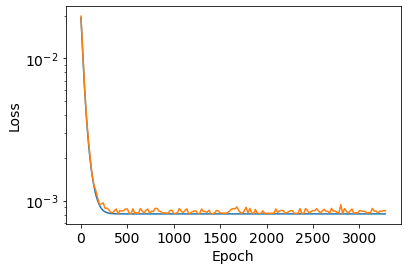

In [25]:
plt.plot(train_losses2)
plt.plot(np.arange(0,len(train_losses2),20),valid_losses2)
plt.yscale('log')
plt.ylabel('Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

torch.Size([1, 1, 7]) tensor([[[0.0233, 0.0547, 0.2237, 0.3966, 0.2237, 0.0547, 0.0233]]],
       grad_fn=<SoftmaxBackward0>)


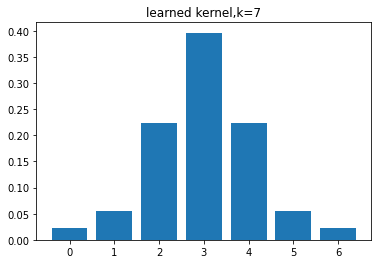

In [10]:
'visualiza the learned kernel'
for idx,param in enumerate(model.parameters()):
    print(param.shape,F.softmax(param,dim=-1))
    plt.bar(range(kernel_size),F.softmax(param[0,0,:],dim=-1).detach())
    plt.title(f'learned kernel,k={kernel_size}')
    plt.show()

In [11]:
# kernel_size = 5
# seed = 2052
# model = torch.load(f'./models/diffusion_dynamic_k={kernel_size}_{seed}.pth')

In [12]:
'generate test data'
'1d'
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
seed = 2050
np.random.seed(seed)
    
# 参数设置
T = 100 # 总时间
dt = 1  # 时间步长
steps = int(T/dt)
space = np.arange(0,99,1)
D =0.5
L = len(space)
pt = np.zeros([steps,L])
center = np.random.randint(40,60)
print(L,center)
pt[0,center] = 1
for step in range(steps-1):
    step = step+1
    pt[step,:] = 1/(np.sqrt(4*np.pi*D*step)) * np.exp(-(space-center)**2/(4*D*step))

pt = torch.tensor(pt,dtype=torch.float)

99 41


In [13]:
pred = model(pt)
pt.shape,pred.shape

(torch.Size([100, 99]), torch.Size([100, 99]))

In [14]:
torch.mean(abs(pt[1:] - pred.detach()[:-1,:]))

tensor(6.4662e-05)

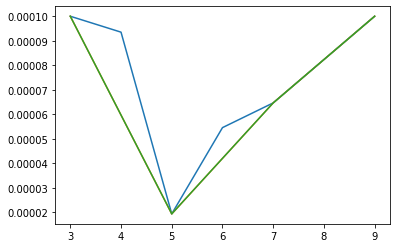

In [15]:
'2050'
plt.plot([3,4,5,6,7,9],[0.0001,9.3510e-05,1.9393e-05,5.4571e-05, 6.4662e-05,0.0001])
'2051'
plt.plot([3,5,7,9],[0.0001,1.9380e-05,6.4662e-05,0.0001])
plt.plot([3,5,7,9],[0.0001,1.9404e-05,6.4662e-05,0.0001])

